In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from finite_env import BlackjackFiniteEnv
from agent import Agent_finite_deck

In [ ]:
# agent and env configuration 

min_train_decks = 1      # Min number of decks during training
max_train_decks = 8     # Max number of decks during training
num_episodes = 1000000    # episodes to train on
alpha = 0.01 # Learning Rate
gamma = 0.98 # Discount Factor
start_epsilon = 1.0 # Start with 100% exploration
min_epsilon = 0.005 # Minimum exploration floor

# dynamic Decay - reach min_epsilon at 90% of training
target_decay_episodes = num_episodes * 0.9 
epsilon_decay = (min_epsilon / start_epsilon) ** (1 / target_decay_episodes)

# Initialize Environment & agent
env = BlackjackFiniteEnv(num_decks=1) 
agent = Agent_finite_deck(
    alpha=alpha,
    gamma=gamma,
    epsilon=start_epsilon,
    min_epsilon=min_epsilon,
    epsilon_decay=epsilon_decay
)
stats = {"rewards": [], "epsilon": [], "hands_per_episode": [], "decks":[]}

In [21]:
# def for multiple decks
def get_universal_state(self):
    # Recalculate hand value locally
    def local_hand_value(cards):
        t = sum(cards)
        if 1 in cards and t + 10 <= 21:
            t += 10
        return t, False 

    total, _ = local_hand_value(self.player_cards)
    usable_ace = (1 in self.player_cards and sum(self.player_cards) + 10 <= 21)
    
    # 1. NORMALIZE DECK DEPTH ("Decks Remaining")
    decks_remaining = len(self.deck) / 52.0
    decks_bucket = round(decks_remaining * 2) / 2  # Round to nearest 0.5
    
    # 2. TRUE COUNT (The Universal Metric)
    # Formula: Running Count / Decks Remaining
    divisor = max(0.5, decks_remaining) # Prevent division by zero
    true_count = self.running_count / divisor
    
    # Bucket True Count (-3 to +3 is the critical range)
    if true_count >= 3: tc_bucket = 3
    elif true_count >= 1: tc_bucket = 1
    elif true_count <= -3: tc_bucket = -3
    elif true_count <= -1: tc_bucket = -1
    else: tc_bucket = 0
    
    return (total, usable_ace, tc_bucket, decks_bucket)

# Apply the Universal State fix to the training environment
env.get_state = get_universal_state.__get__(env, BlackjackFiniteEnv)

In [22]:
# training loop
for episode in range(num_episodes):
    # randomize number of decks for each episode
    current_decks = random.randint(min_train_decks, max_train_decks)
    env.num_decks = current_decks
    
    state = env.reset() # Reset reshuffles the deck with the new size
    done = False
    total_episode_reward = 0
    ep_hands = 0
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        if info.get("hand_ended"):
            ep_hands += 1
            
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_episode_reward += reward
        
    agent.decay_epsilon()
    
    stats["rewards"].append(total_episode_reward)
    stats["epsilon"].append(agent.epsilon)
    stats["hands_per_episode"].append(ep_hands)
    stats["decks"].append(current_decks)
    
    if (episode + 1) % 1000 == 0:
        # We now print the specific stats for THIS episode, including the deck count
        print(f"Episode {episode + 1}/{num_episodes} | "
              f"Decks: {current_decks} | "       # Shows deck size used this episode
              f"Reward: {total_episode_reward:.0f} | " # score this episode
              f"Epsilon: {agent.epsilon:.4f} | " # Current exploration rate
              f"Hands: {ep_hands}") # number of hands played this episode

Episode 1000/1000000 | Decks: 4 | Reward: 12616 | Epsilon: 0.9941 | Hands: 110
Episode 2000/1000000 | Decks: 6 | Reward: 18936 | Epsilon: 0.9883 | Hands: 157
Episode 3000/1000000 | Decks: 5 | Reward: 17881 | Epsilon: 0.9825 | Hands: 135
Episode 4000/1000000 | Decks: 1 | Reward: 2260 | Epsilon: 0.9767 | Hands: 30
Episode 5000/1000000 | Decks: 5 | Reward: 16407 | Epsilon: 0.9710 | Hands: 131
Episode 6000/1000000 | Decks: 3 | Reward: 9322 | Epsilon: 0.9653 | Hands: 75
Episode 7000/1000000 | Decks: 5 | Reward: 16129 | Epsilon: 0.9596 | Hands: 142
Episode 8000/1000000 | Decks: 7 | Reward: 24027 | Epsilon: 0.9540 | Hands: 195
Episode 9000/1000000 | Decks: 6 | Reward: 21708 | Epsilon: 0.9484 | Hands: 161
Episode 10000/1000000 | Decks: 4 | Reward: 12880 | Epsilon: 0.9428 | Hands: 114
Episode 11000/1000000 | Decks: 3 | Reward: 11170 | Epsilon: 0.9373 | Hands: 91
Episode 12000/1000000 | Decks: 2 | Reward: 6689 | Epsilon: 0.9318 | Hands: 59
Episode 13000/1000000 | Decks: 8 | Reward: 28418 | Epsil

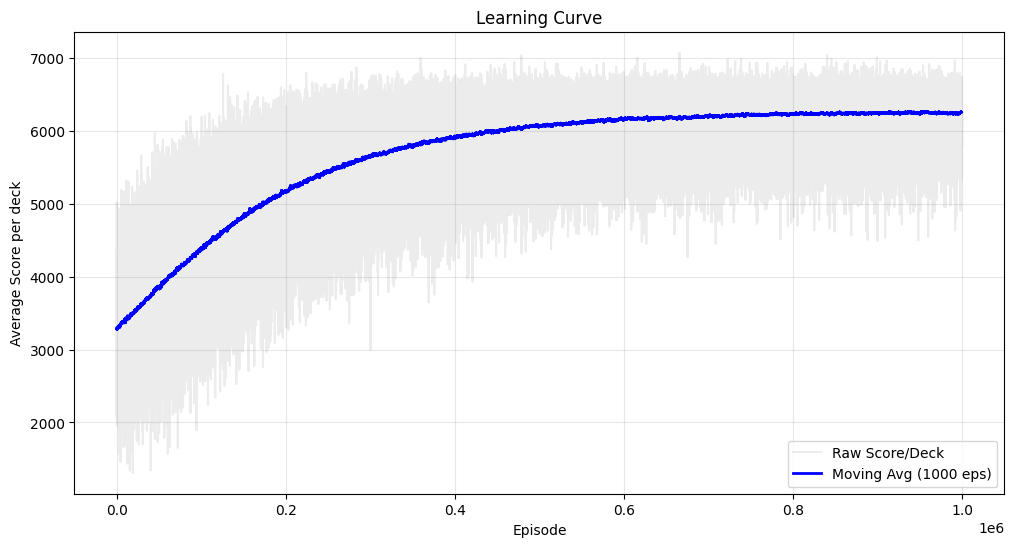

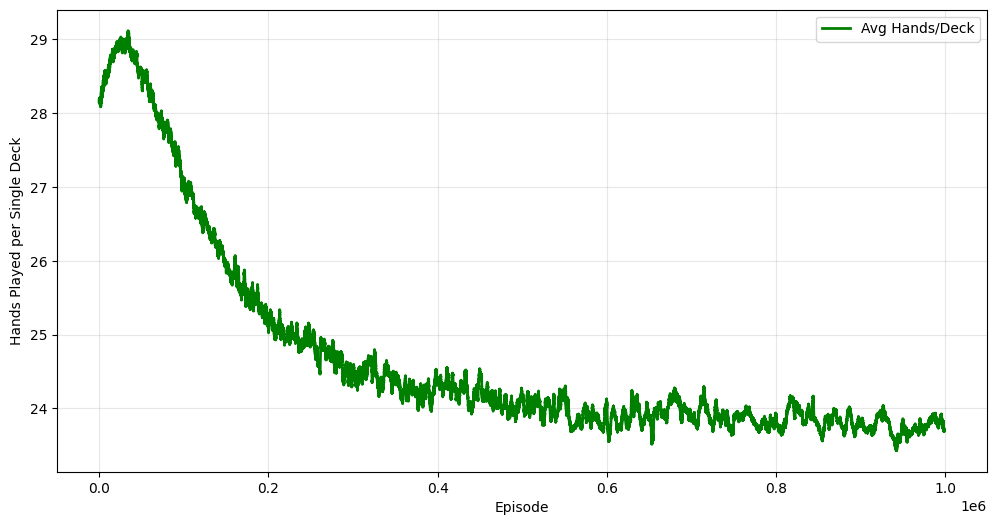

In [27]:
#plots from training stats
rewards = np.array(stats["rewards"])
decks = np.array(stats["decks"])
hands = np.array(stats["hands_per_episode"])
norm_rewards = (rewards / decks) # avg reward per deck
norm_hands = (hands / decks) # avg hands per deck


def moving_average(data, window_size=1000):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
# Normalized Reward
plt.figure(figsize=(12, 6))
plt.plot(norm_rewards, alpha=0.15, color='gray', label='Raw Score/Deck')
plt.plot(moving_average(norm_rewards), color='blue', linewidth=2, label='Moving Avg (1000 eps)')
plt.xlabel('Episode')
plt.ylabel('Average Score per deck')
plt.title('Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 2: avg Hands per Deck
plt.figure(figsize=(12, 6))
plt.plot(moving_average(norm_hands), color='green', linewidth=2, label='Avg Hands/Deck')
plt.xlabel('Episode')
plt.ylabel('Hands Played per Single Deck')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Evaluation for (5 decks)
Episodes Evaluated:      1000
Average Score:           31530.82.
Highest Score:           32886
Lowest Score:            29674
Score Std Dev:           507.86
Avg Hands per Shoe:      117.31
Bust Rate:               0.05%
Hit vs Stick Ratio:      54.9% Hits / 45.1% Sticks
check baseline performance for reference


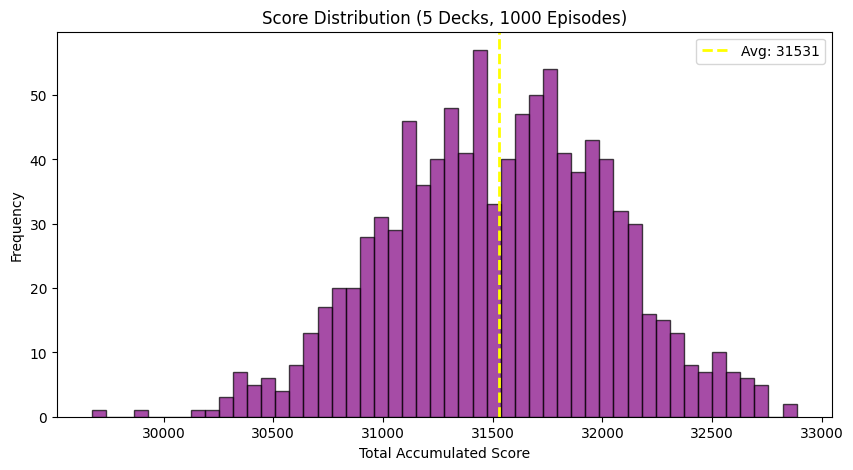

In [30]:
# evaluation loop
eval_on_decks = 5 # decks to evaluate on
n_eval_episodes = 1000
eval_env = BlackjackFiniteEnv(num_decks=eval_on_decks)
eval_env.get_state = get_universal_state.__get__(eval_env, BlackjackFiniteEnv)

eval_stats = {
    "scores": [],
    "hands_per_episode": [],
    "total_hands": 0,
    "busts": 0,
    "hits": 0,
    "sticks": 0
}

# set exploration to 0
original_epsilon = agent.epsilon
agent.epsilon = 0.0

for i in range(n_eval_episodes):
    state = eval_env.reset()
    done = False
    score = 0
    h = 0
    
    while not done:
        action = agent.get_action(state)
        
        # Track Actions
        if action == 1: eval_stats["hits"] += 1
        else: eval_stats["sticks"] += 1
            
        state, reward, done, info = eval_env.step(action)
        score += reward
        
        # Track Hand Outcomes
        if info.get("hand_ended"):
            h += 1
            eval_stats["total_hands"] += 1
            if info.get("bust", False):
                eval_stats["busts"] += 1
                
    eval_stats["scores"].append(score)
    eval_stats["hands_per_episode"].append(h)

# Restore Epsilon
agent.epsilon = original_epsilon

# stats
avg_score = np.mean(eval_stats["scores"])
max_score = np.max(eval_stats["scores"])
min_score = np.min(eval_stats["scores"])
std_dev = np.std(eval_stats["scores"])
avg_hands = np.mean(eval_stats["hands_per_episode"])
bust_rate = (eval_stats["busts"] / eval_stats["total_hands"]) * 100 if eval_stats["total_hands"] > 0 else 0
total_actions = eval_stats["hits"] + eval_stats["sticks"]
hit_rate = (eval_stats["hits"] / total_actions) * 100 if total_actions > 0 else 0

print(f"Evaluation for ({eval_on_decks} decks)")
print(f"Episodes Evaluated:      {n_eval_episodes}")
print(f"Average Score:           {avg_score:.2f}.")
print(f"Highest Score:           {max_score}")
print(f"Lowest Score:            {min_score}")
print(f"Score Std Dev:           {std_dev:.2f}")
print(f"Avg Hands per Shoe:      {avg_hands:.2f}")
print(f"Bust Rate:               {bust_rate:.2f}%")
print(f"Hit vs Stick Ratio:      {hit_rate:.1f}% Hits / {100-hit_rate:.1f}% Sticks")
print("check baseline performance for reference")

# score distribution
plt.figure(figsize=(10, 5))
plt.hist(eval_stats["scores"], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(avg_score, color='yellow', linestyle='dashed', linewidth=2, label=f'Avg: {avg_score:.0f}')
plt.title(f"Score Distribution ({eval_on_decks} Decks, {n_eval_episodes} Episodes)")
plt.xlabel("Total Accumulated Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()